In [29]:
import copy
import pandas
import warnings
import subprocess
from matplotlib import pyplot as plt
import os
import sys
from scipy import stats
import numpy 
import pprint

sys.path.insert(0, "../src")

from perf_tools.analysis import make_differential_frame, get_data, get_summary_statistics
from perf_tools.analysis import check_are_close, make_latency_plot, plot_latency_stats

In [49]:
VARIANTS = {"replset": "linux-1-node-replSet-fle.2022-11", "sharded": "linux-shard-lite-fle.2022-11"}

WORKDIR_60="../datasets/genny2/perf_criteria_60"
WORKDIR_70="../datasets/genny2/perf_criteria_70"

WORKDIR_60_UNENCRYPTED="../datasets/genny2/perf_criteria_60_unencrypted"
WORKDIR_70_UNENCRYPTED="../datasets/genny2/perf_criteria_70_unencrypted"

patch_id_60 = "63eabf977742ae6326005452"
patch_id_70 = "6446ddad2fbabe4926f29745"


patch_id_60_unencrypted = "63ff7af9d1fe076ac67ff129"
patch_id_70_unencrypted = "63ff7b47850e612de432a941"

exec_idx=0

class PerfCriteriaCache:
    def __init__(self, workdir, patch_id, variant, execution, task_name):
        self.workdir = workdir
        self.patch_id = patch_id
        self.variant = variant
        self.execution = execution
        self.task_name = task_name
        self.ldata = None
        self.qdata = None

        self.udata = None


    def json_path(self, metric):
        return os.path.join(self.workdir, self.patch_id, self.variant,
            self.task_name, str(self.execution), metric + ".json")

    def get_data(self):
        if self.ldata is None:
            self.ldata = get_data(self.json_path("InsertActor.load.inserts"))
        return self.ldata


    def get_query_data(self):
        if self.qdata is None:
            self.qdata = get_data(self.json_path("InsertActor.FSM.query"))
        return self.qdata
    

    def get_update_data(self):
        if self.udata is None:
            self.udata = get_data(self.json_path("InsertActor.FSM.update"))
        return self.udata
    
pc_60_e = PerfCriteriaCache(WORKDIR_60, patch_id_60, VARIANTS["sharded"], "0",  "medical_workload_load" )
pc_60_ue = PerfCriteriaCache(WORKDIR_60_UNENCRYPTED, patch_id_60_unencrypted, VARIANTS["sharded"], "0",  "medical_workload_load_unencrypted" )


pc_70_e = PerfCriteriaCache(WORKDIR_70, patch_id_70, VARIANTS["sharded"], "0",  "medical_workload_load" )
pc_70_ue = PerfCriteriaCache(WORKDIR_70_UNENCRYPTED, patch_id_70_unencrypted, VARIANTS["sharded"], "0",  "medical_workload_load_unencrypted" )


In [5]:

def get_summary_statistics_df(pc,task):
    l1 = pc.get_data()
    b = l1.diff_data
    fixed_data = l1.fixed_data
    raw_data = l1.raw_data

    quantiles = stats.mstats.mquantiles(b.loc[:,"pure_latency"].values, prob=[0.5,0.8,0.9,0.95,0.99], alphap=1/3, betap=1/3)
    averages = b.mean(numeric_only=True)
    maximum = b.max()
    minimum = b.min()
    duration = (b["ts"][len(b)-1] - b["ts"][0]).total_seconds()
    ops = fixed_data["d(ops)"].sum()
    size = fixed_data["d(size)"].sum()
    docs = fixed_data["d(n)"].sum()
    errs = fixed_data["d(err)"].sum()
    overhead = fixed_data["d(t_overhead)"].sum()

    df1 = pandas.DataFrame(index = [0], data = {
        'Task': task,
        'AverageLatency': averages["pure_latency"],
        'AverageLatencyMillis': averages["pure_latency(ms)"],
        'AverageSize': size / ops,
        'OperationThroughput': ops / duration,
        'DocumentThroughput': docs / duration,
        'SizeThroughput': size / duration,
        'ErrorRate': errs / duration,
        'Latency50thPercentile': quantiles[0],
        'Latency80thPercentile': quantiles[1],
        'Latency90thPercentile': quantiles[2],
        'Latency95thPercentile': quantiles[3],
        'Latency99thPercentile': quantiles[4],
        'Latency50thPercentileMillis': quantiles[0] / 1000000,
        'Latency80thPercentileMillis': quantiles[1] / 1000000,
        'Latency90thPercentileMillis': quantiles[2] / 1000000,
        'Latency95thPercentileMillis': quantiles[3] / 1000000,
        'Latency99thPercentileMillis': quantiles[4] / 1000000,
        'WorkersMin': raw_data["gauges.workers"].min(),
        'WorkersMax': raw_data["gauges.workers"].max(),
        'LatencyMax': maximum["pure_latency"],
        'LatencyMin': minimum["pure_latency"],
        'DurationTotal': duration * 1e9,
        'ErrorsTotal': errs,
        'OperationsTotal': ops,
        'DocumentsTotal': docs,
        'SizeTotal': size,
        'OverheadTotal': overhead
    })

    return df1

pp = pprint.PrettyPrinter()

# def print_sum(pc):

#     pc = pc
#     l1 = pc.get_data()

#     a = get_summary_statistics(l1.diff_data, l1.fixed_data, l1.raw_data)
#     pp.pprint(a)

# print_sum(pc_60_e)
# print_sum(pc_70_e)


df_une = get_summary_statistics_df(pc_60_ue, "60_unencrypted")
df_60 = get_summary_statistics_df(pc_60_e, "60")
df_70 = get_summary_statistics_df(pc_70_e, "70")

df = pandas.concat([df_une, df_60, df_70], ignore_index=True)

df.to_csv("/tmp/summary.csv")
df
# sdf

FileNotFoundError: [Errno 2] No such file or directory: '../datasets/genny2/perf_criteria_60_unencrypted/63ff7af9d1fe076ac67ff129/linux-1-node-replSet-fle.2022-11/insert_only_unencrypted/0/InsertActor.load.inserts.json'

In [50]:
pc_70_cc = PerfCriteriaCache(WORKDIR_70, patch_id_70, VARIANTS["sharded"], "0",  "medical_workload_credit_cards_50_50" )
pc_70_d = PerfCriteriaCache(WORKDIR_70, patch_id_70, VARIANTS["sharded"], "0",  "medical_workload_diagnosis_50_50" )


In [60]:
av =  pc_70_d.get_query_data().diff_data["pure_latency(ms)"]
"Median: " + str(numpy.median(av))
# "Mean: " + str(numpy.mean(av))


'Median: 2.9795735'

In [62]:
pc_70_d.get_query_data().diff_data.query("`pure_latency(ms)` > 10000")

# 439 > 100
# 49787 < 100

,d(ops),d(t_pure),d(t_total),d(t_overhead),total_latency,total_latency(ms),overhead_latency,overhead_latency(ms),pure_latency,pure_latency(ms),ts,actor_id,total_ops,duration,throughput,mean_pure_latency,mean_pure_latency(ms),median_pure_latency,median_pure_latency(ms)
15404,1.0,1.063685e+10,1.063718e+10,321324.0,1.063718e+10,10637.175423,321324.0,0.321324,1.063685e+10,10636.854099,2023-04-24 22:01:13.352000000,2,15405.0,26.851,573.721648,1.079323e+07,10.793232,3095324.0,3.095324
16699,1.0,1.086802e+10,1.089376e+10,25743279.0,1.089376e+10,10893.763768,25743279.0,25.743279,1.086802e+10,10868.020489,2023-04-24 22:01:16.563000064,13,16700.0,30.062,555.518593,1.150888e+07,11.508885,3090581.5,3.090581
16757,1.0,1.171309e+10,1.171343e+10,336857.0,1.171343e+10,11713.431057,336857.0,0.336857,1.171309e+10,11713.094200,2023-04-24 22:01:16.716999936,1,16758.0,30.216,554.606831,1.218012e+07,12.180122,3090306.5,3.090307
19106,1.0,1.804831e+10,1.806329e+10,14983397.0,1.806329e+10,18063.291373,14983397.0,14.983397,1.804831e+10,18048.307976,2023-04-24 22:01:22.391000064,7,19107.0,35.890,532.376705,1.292806e+07,12.928062,3084247.0,3.084247
23049,1.0,1.921731e+10,1.921768e+10,364369.0,1.921768e+10,19217.677920,364369.0,0.364369,1.921731e+10,19217.313551,2023-04-24 22:01:33.152999936,16,23050.0,46.652,494.083855,1.380284e+07,13.802838,3066909.5,3.066909
26731,1.0,4.494847e+10,4.494882e+10,347170.0,4.494882e+10,44948.821045,347170.0,0.347170,4.494847e+10,44948.473875,2023-04-24 22:01:44.596999936,11,26732.0,58.096,460.134949,1.529492e+07,15.294916,3054446.0,3.054446
31353,1.0,2.373612e+10,2.374777e+10,11648111.0,2.374777e+10,23747.768938,11648111.0,11.648111,2.373612e+10,23736.120827,2023-04-24 22:02:12.191000064,9,31354.0,85.690,365.900338,1.573053e+07,15.730527,3037642.0,3.037642
31710,1.0,5.180412e+10,5.180447e+10,354457.0,5.180447e+10,51804.471450,354457.0,0.354457,5.180412e+10,51804.116993,2023-04-24 22:02:16.771000064,2,31711.0,90.270,351.290572,1.725841e+07,17.258411,3035722.0,3.035722
32347,1.0,1.269727e+10,1.272216e+10,24890159.0,1.272216e+10,12722.156567,24890159.0,24.890159,1.269727e+10,12697.266408,2023-04-24 22:02:25.246000128,3,32348.0,98.745,327.591270,1.762728e+07,17.627280,3034355.5,3.034356
33136,1.0,5.283542e+10,5.283576e+10,340229.0,5.283576e+10,52835.760327,340229.0,0.340229,5.283542e+10,52835.420098,2023-04-24 22:02:31.100000000,13,33137.0,104.599,316.800352,1.900014e+07,19.000144,3032399.0,3.032399


/usr/lib64/python3.11/site-packages/pandas/core/tools/datetimes.py:557: RuntimeWarning: invalid value encountered in cast
  arr, tz_parsed = tslib.array_with_unit_to_datetime(arg, unit, errors=errors)


array([[<Axes: title={'center': 'pure_latency(ms)'}>]], dtype=object)

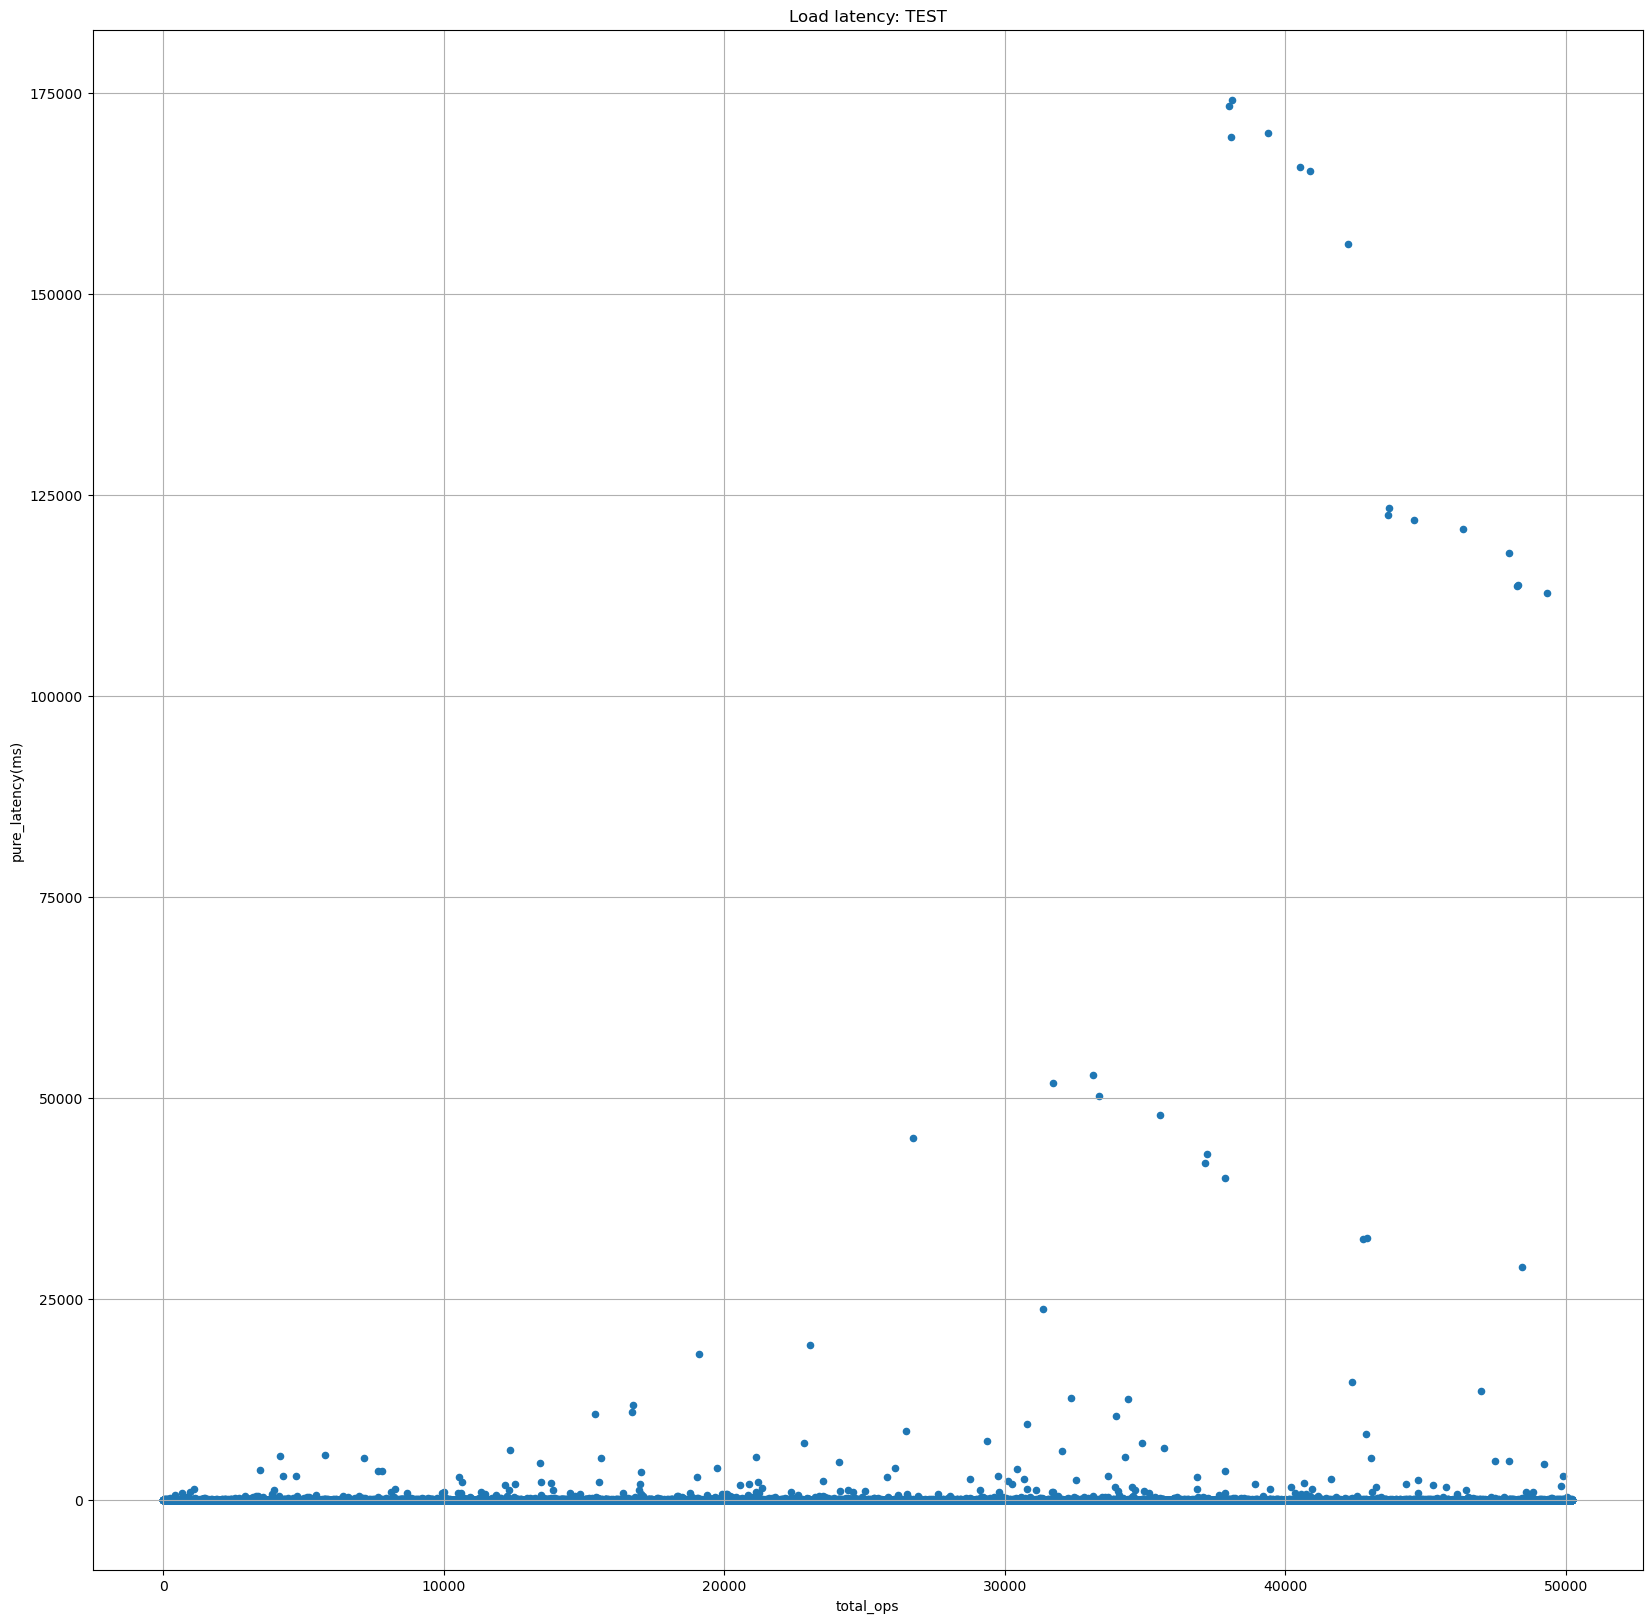

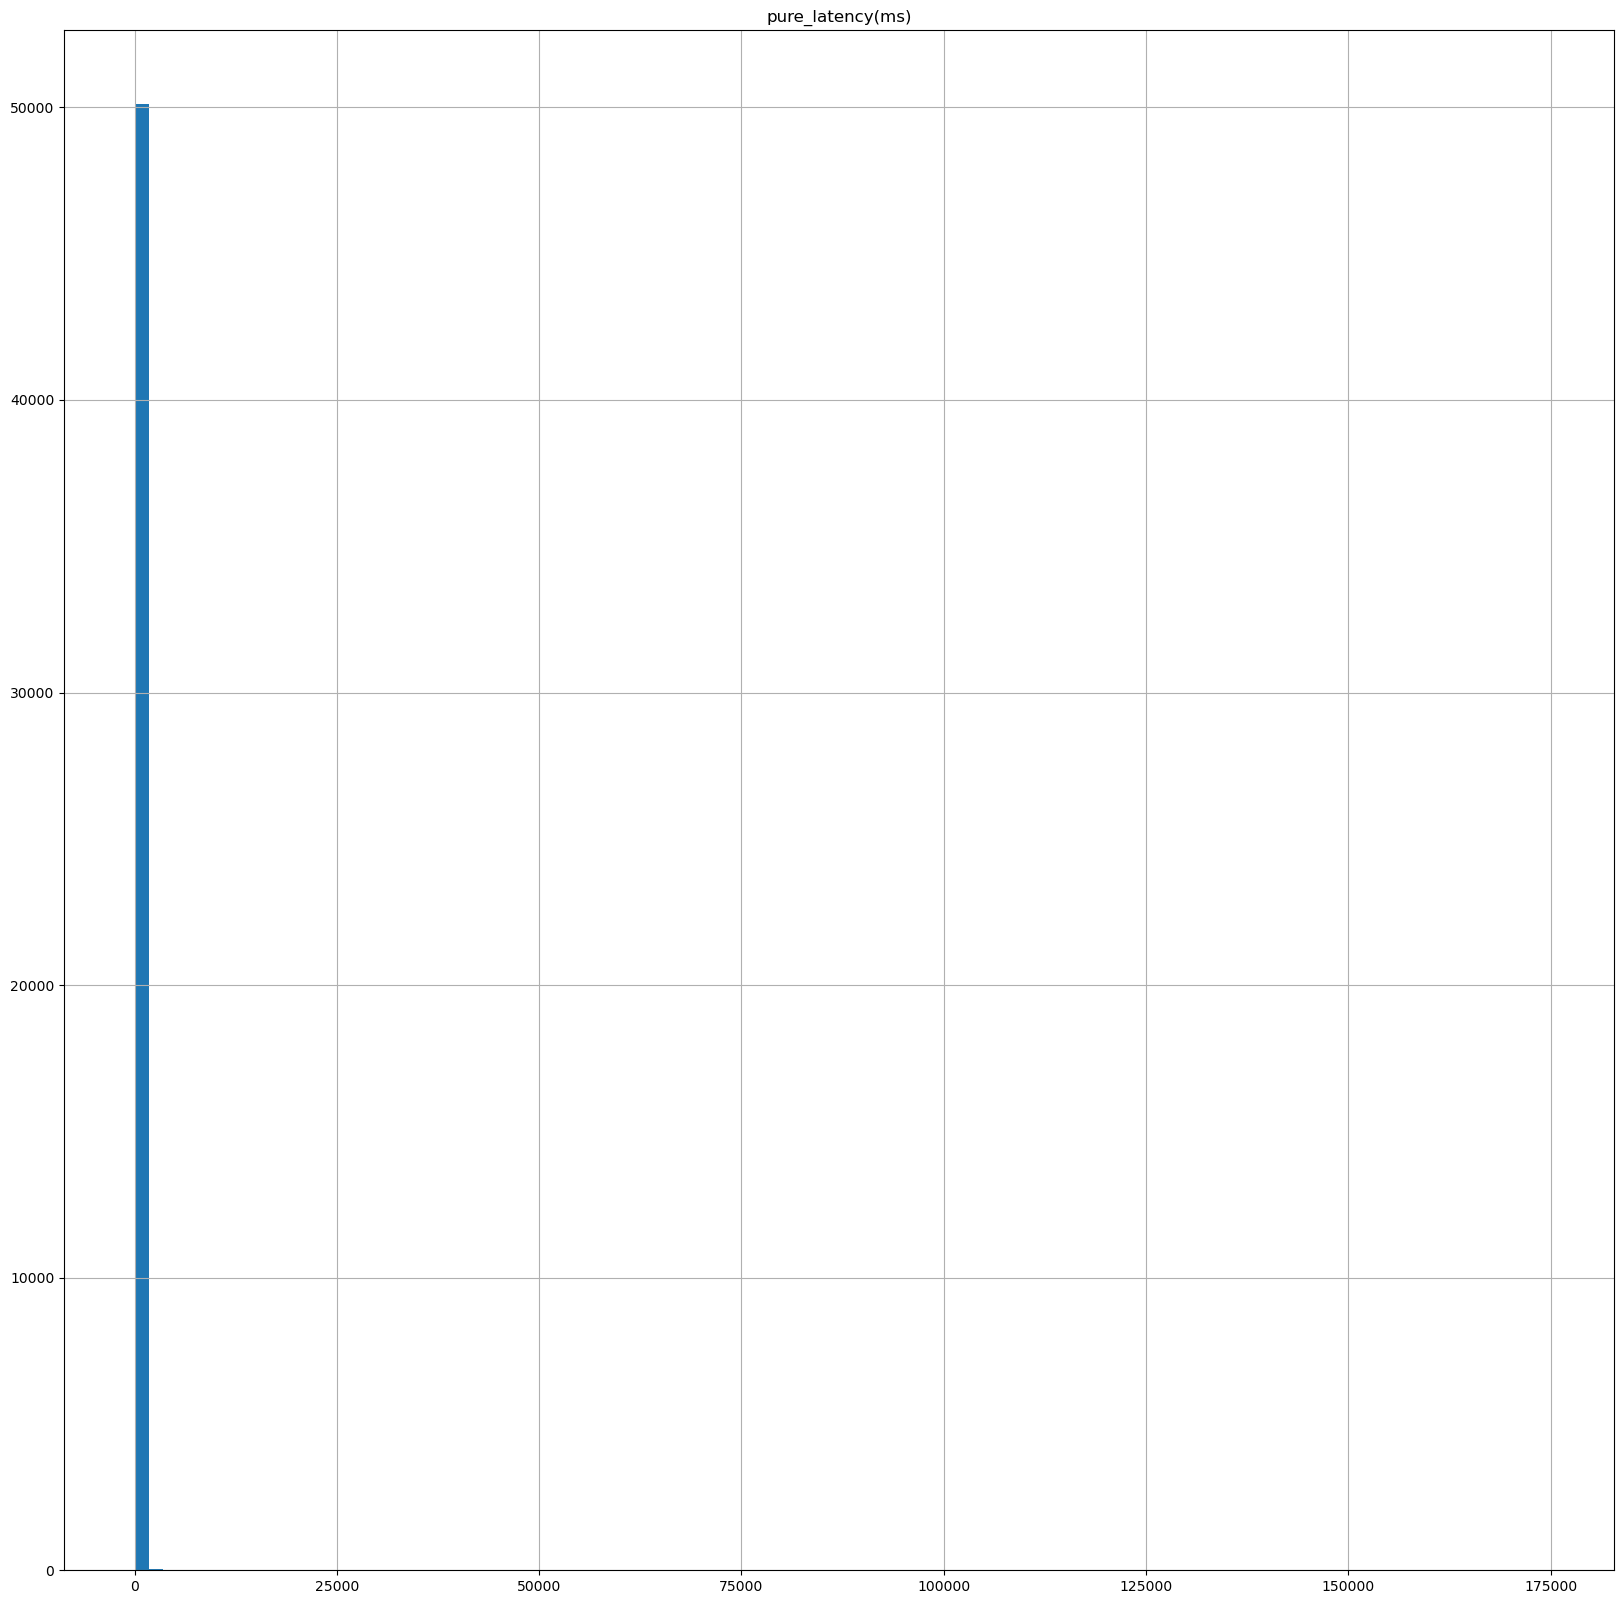

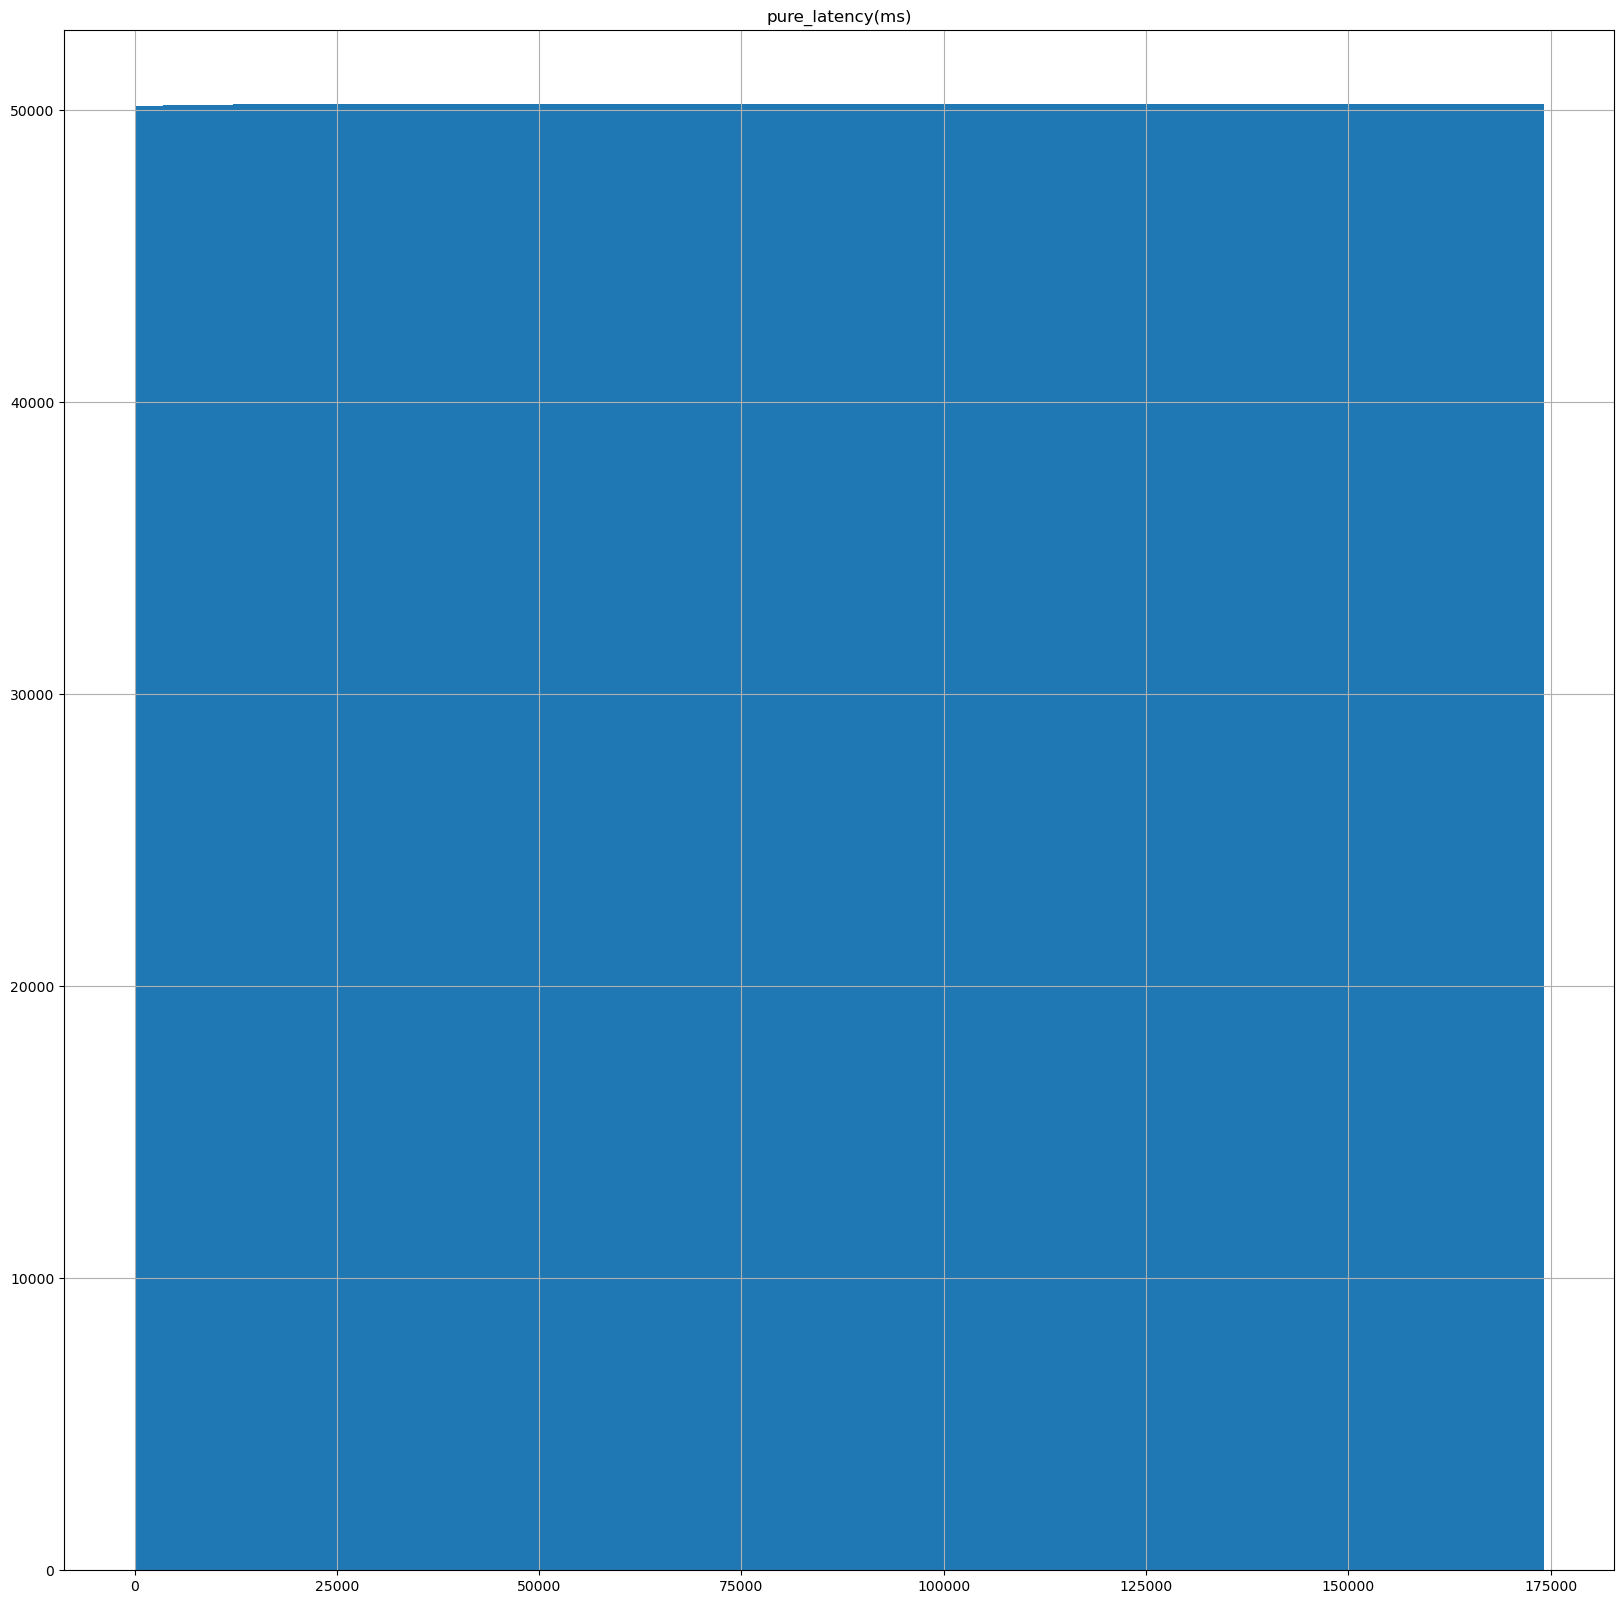

In [53]:
# df = get_summary_statistics_df(pc_e)


# df.to_csv("/tmp/summary.csv")
# df
df_w = pc_70_d.get_query_data().diff_data

# Graph scatter plot of latency
df_w.plot(figsize=(20,20), x="total_ops", y= "pure_latency(ms)", kind="scatter", title=f"Load latency: TEST", ylabel="pure_latency(ms)", grid=0.4)

# Graph latency with trend lines
# plot_latency_stats(df_w, "total_ops", title=f"{experiment} cf_{cf} thread_{tc} insert stats", regr="log", start=start, end=end)
# df_h = df_w.query("`pure_latency(ms)` < 10")

df_w.hist(figsize=(20,20), column= "pure_latency(ms)", bins=100, grid=0.4)

df_w.hist(figsize=(20,20), column= "pure_latency(ms)", bins=100, grid=0.4,cumulative=True)


/usr/lib64/python3.11/site-packages/pandas/core/tools/datetimes.py:557: RuntimeWarning: invalid value encountered in cast
  arr, tz_parsed = tslib.array_with_unit_to_datetime(arg, unit, errors=errors)


array([[<Axes: title={'center': 'pure_latency(ms)'}>]], dtype=object)

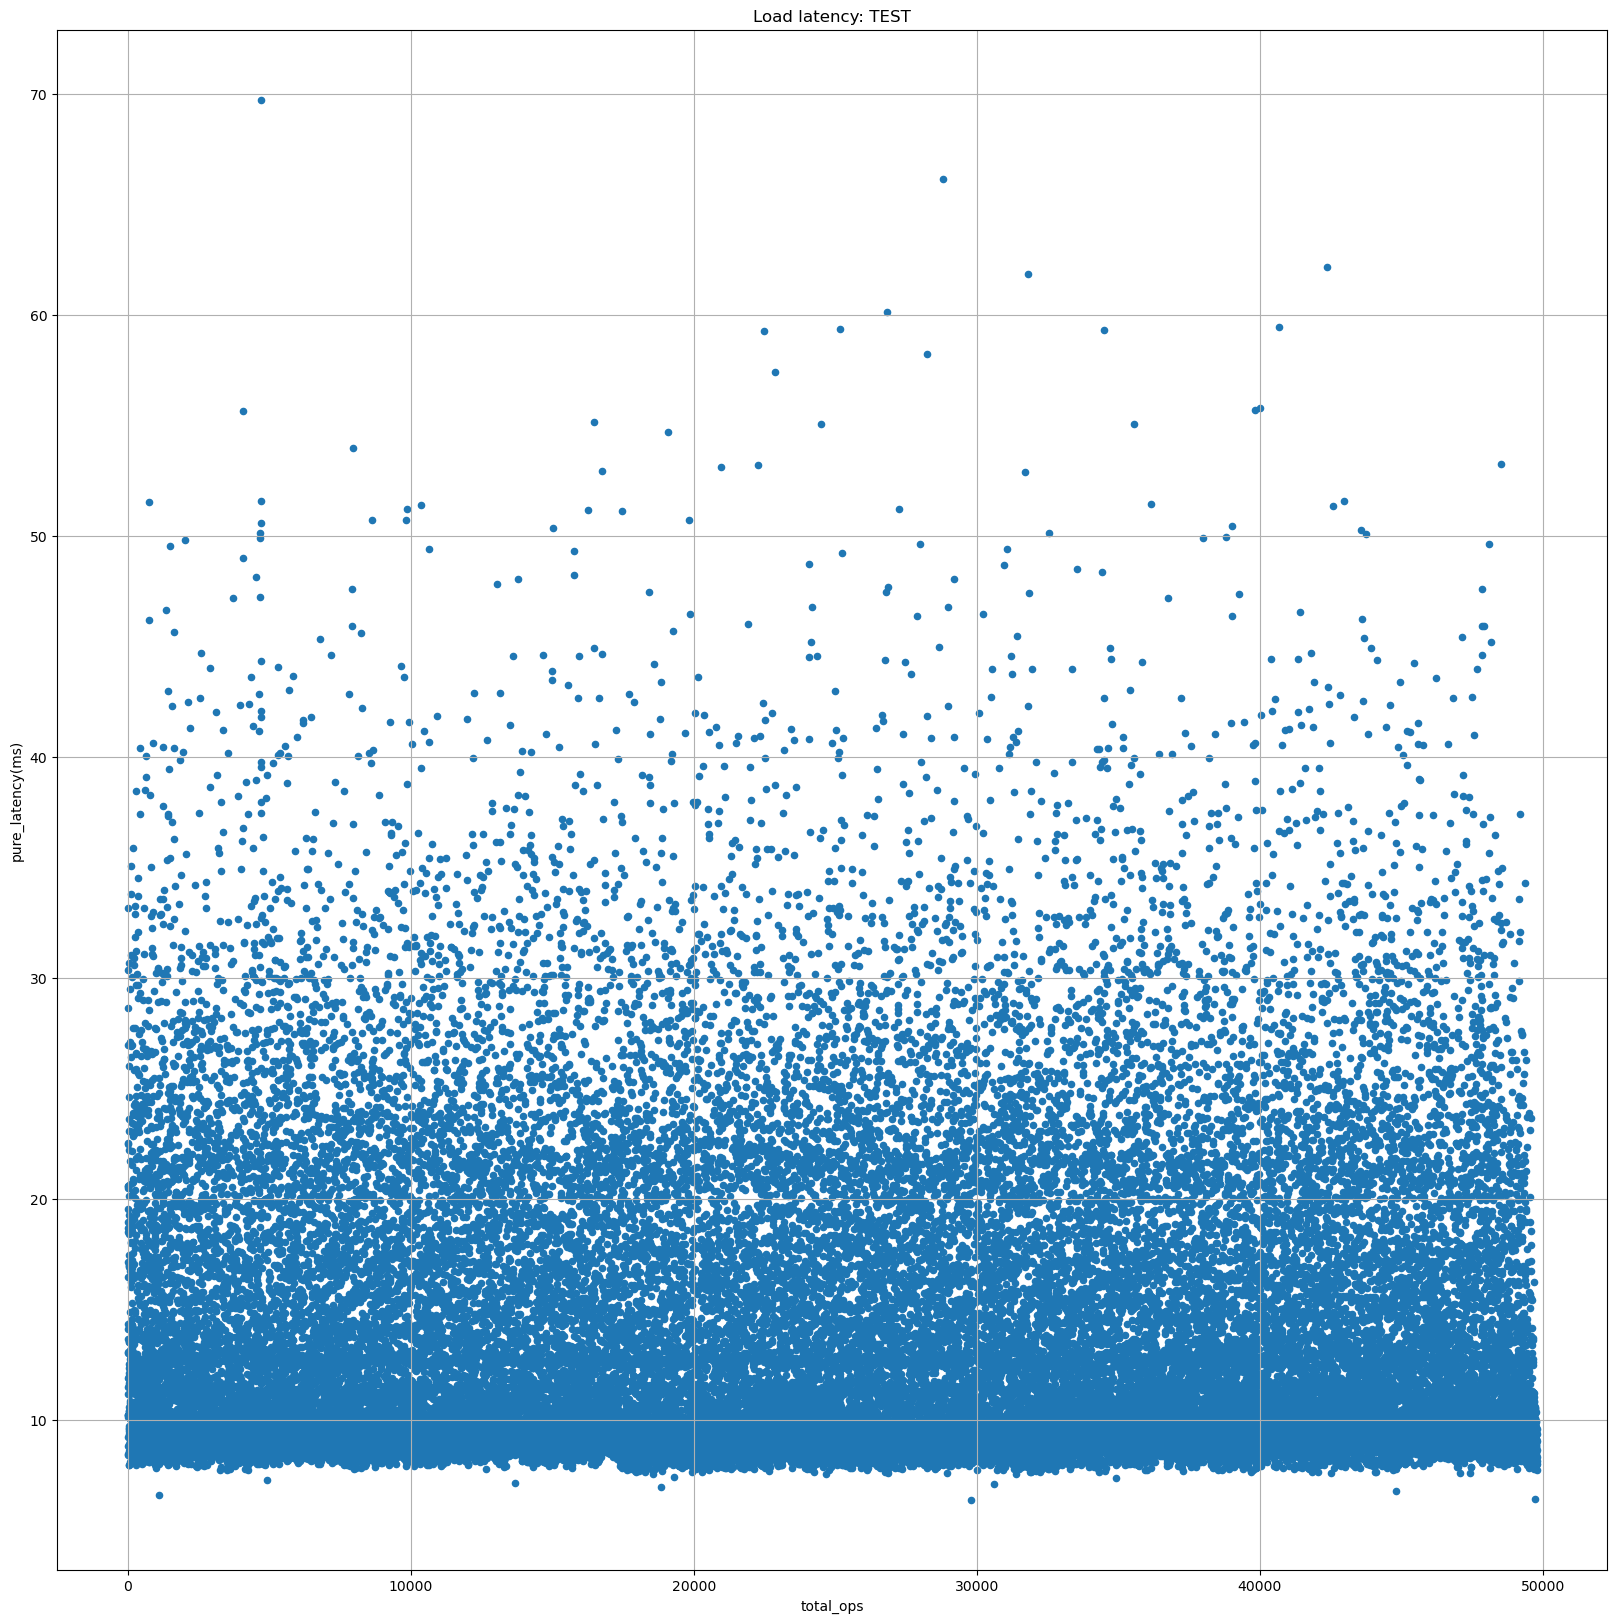

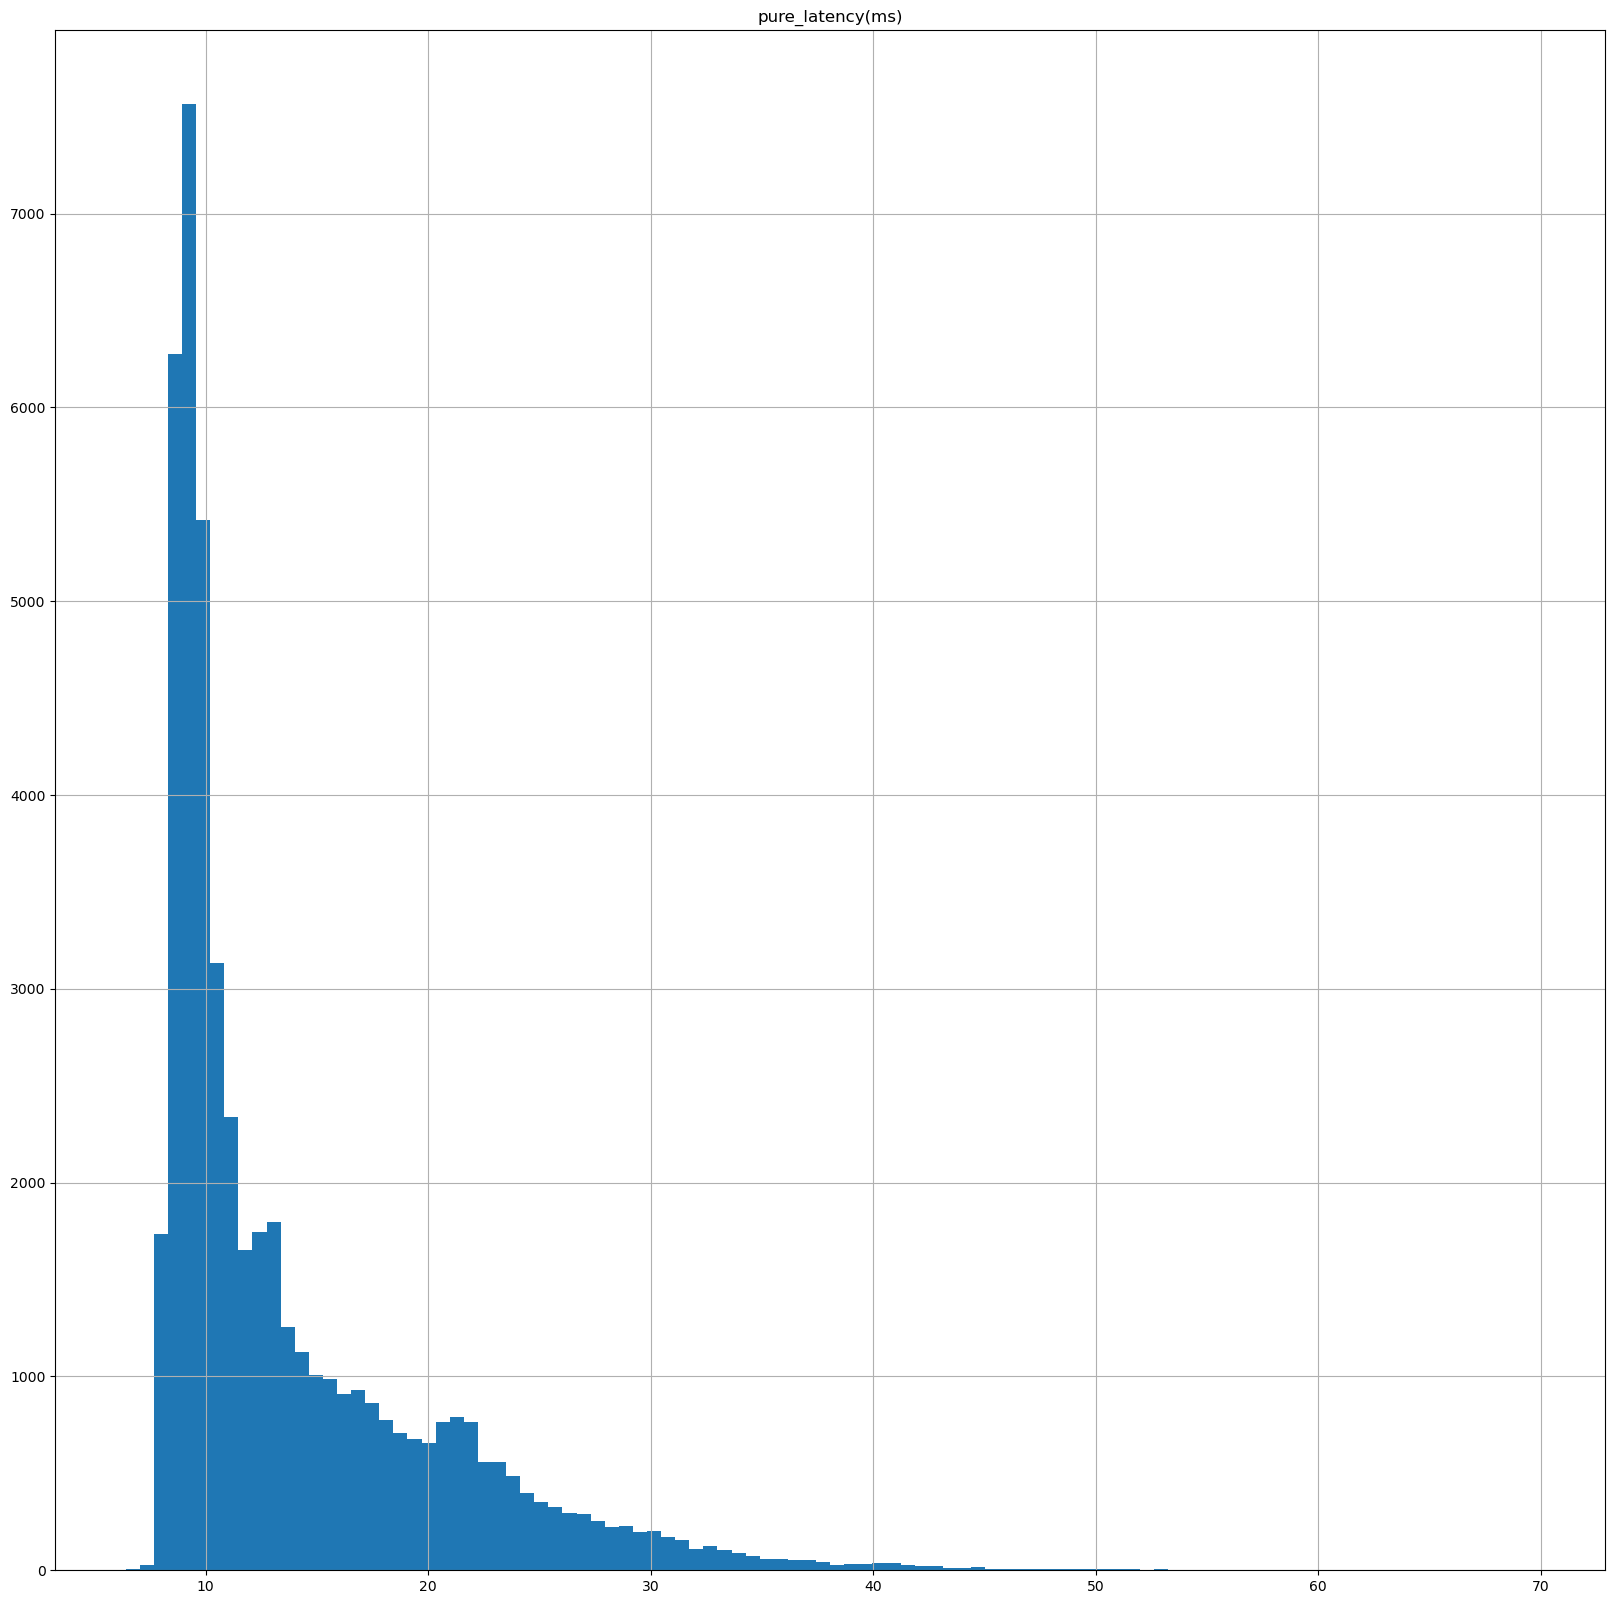

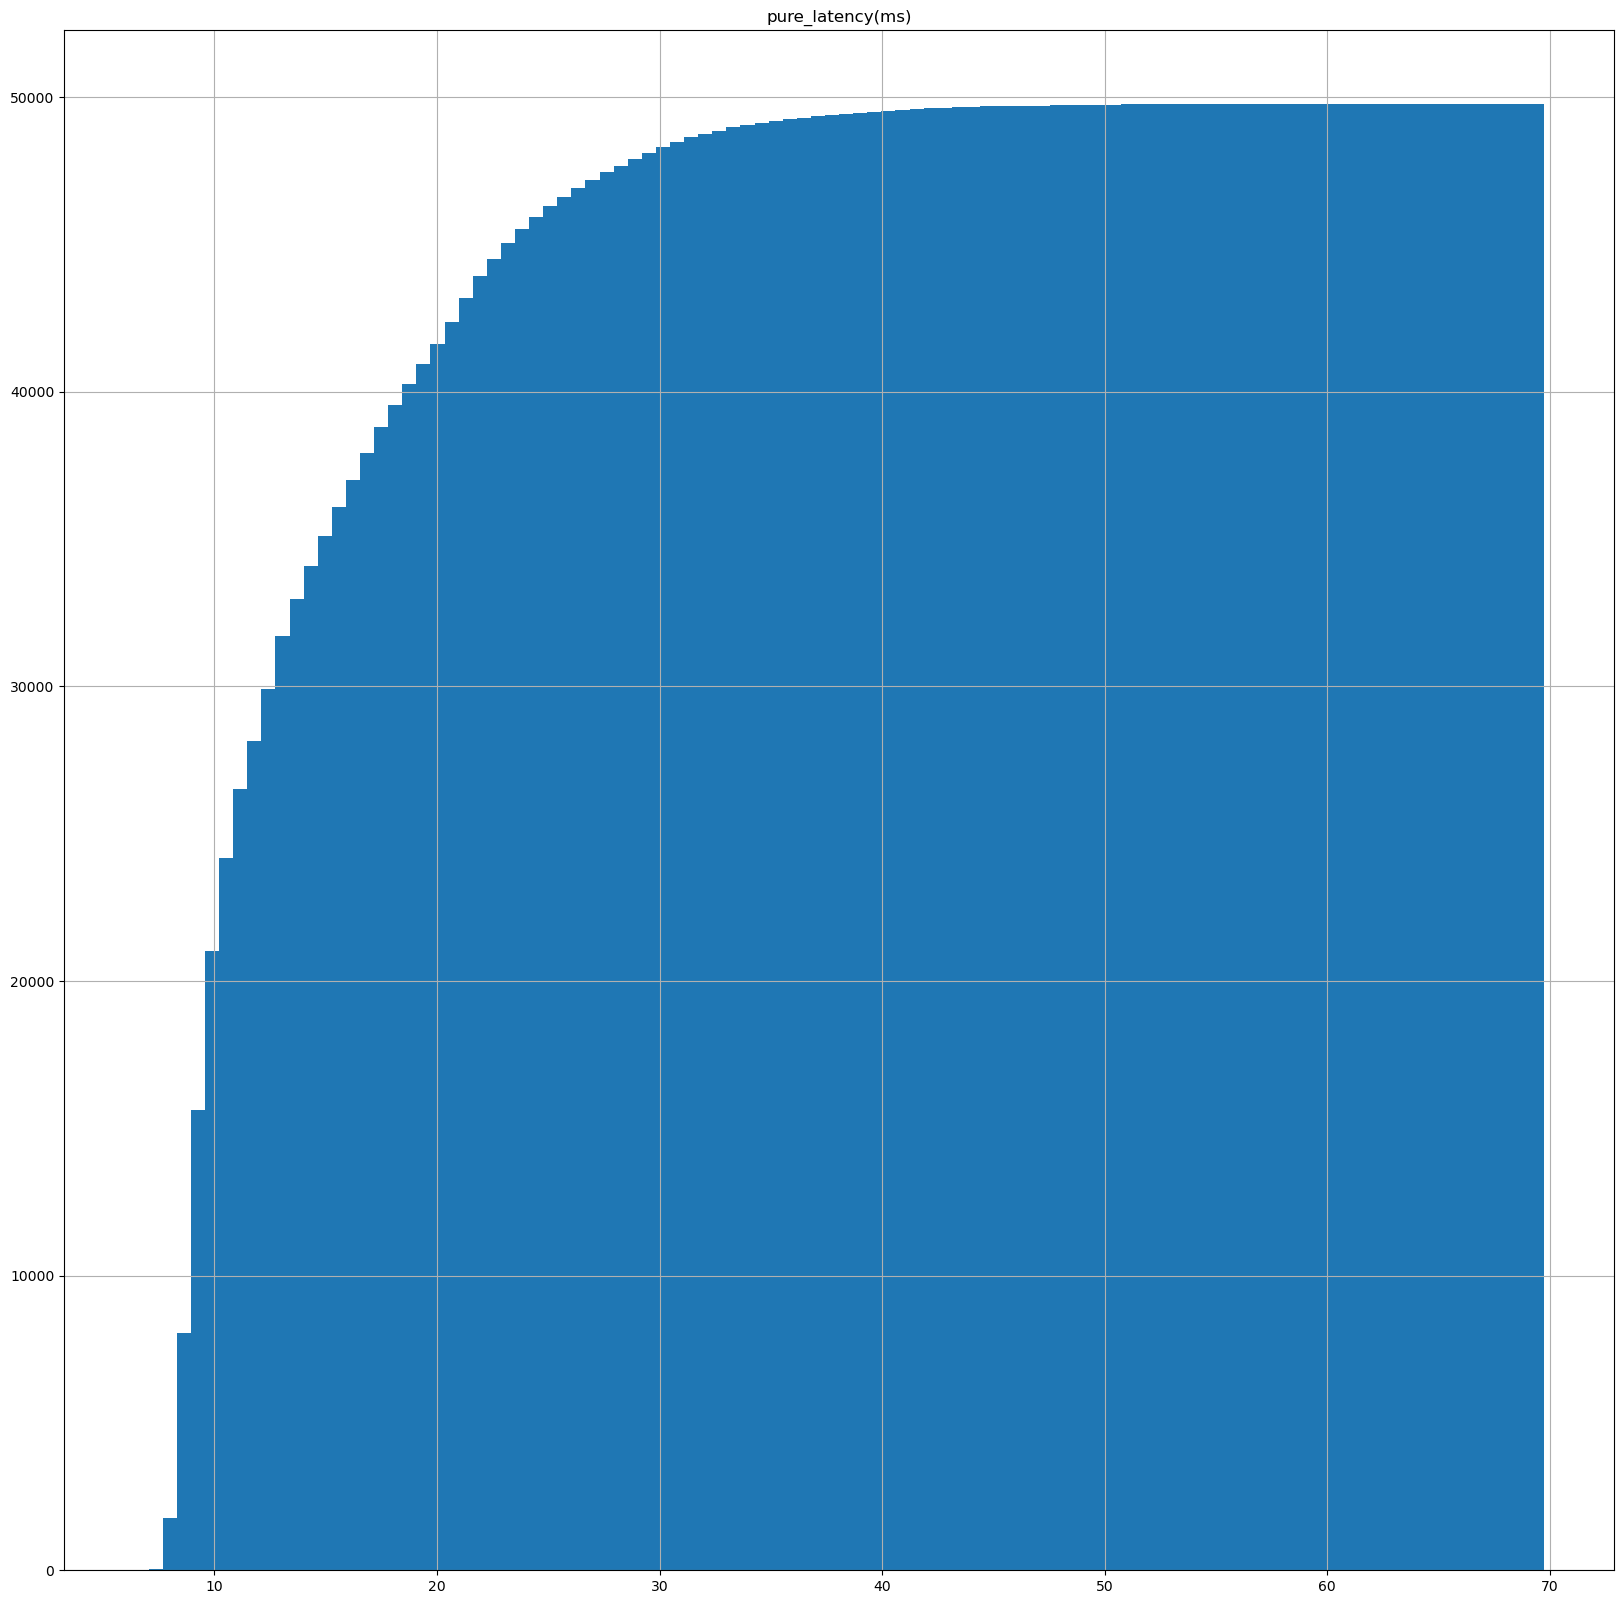

In [52]:
# df = get_summary_statistics_df(pc_e)


# df.to_csv("/tmp/summary.csv")
# df
df_w = pc_70_cc.get_update_data().diff_data

# Graph scatter plot of latency
df_w.plot(figsize=(20,20), x="total_ops", y= "pure_latency(ms)", kind="scatter", title=f"Load latency: TEST", ylabel="pure_latency(ms)", grid=0.4)

# Graph latency with trend lines
# plot_latency_stats(df_w, "total_ops", title=f"{experiment} cf_{cf} thread_{tc} insert stats", regr="log", start=start, end=end)
# df_h = df_w.query("`pure_latency(ms)` < 10")

df_w.hist(figsize=(20,20), column= "pure_latency(ms)", bins=100, grid=0.4)

df_w.hist(figsize=(20,20), column= "pure_latency(ms)", bins=100, grid=0.4,cumulative=True)

/usr/lib64/python3.11/site-packages/pandas/core/tools/datetimes.py:557: RuntimeWarning: invalid value encountered in cast
  arr, tz_parsed = tslib.array_with_unit_to_datetime(arg, unit, errors=errors)


array([[<Axes: title={'center': 'pure_latency(ms)'}>]], dtype=object)

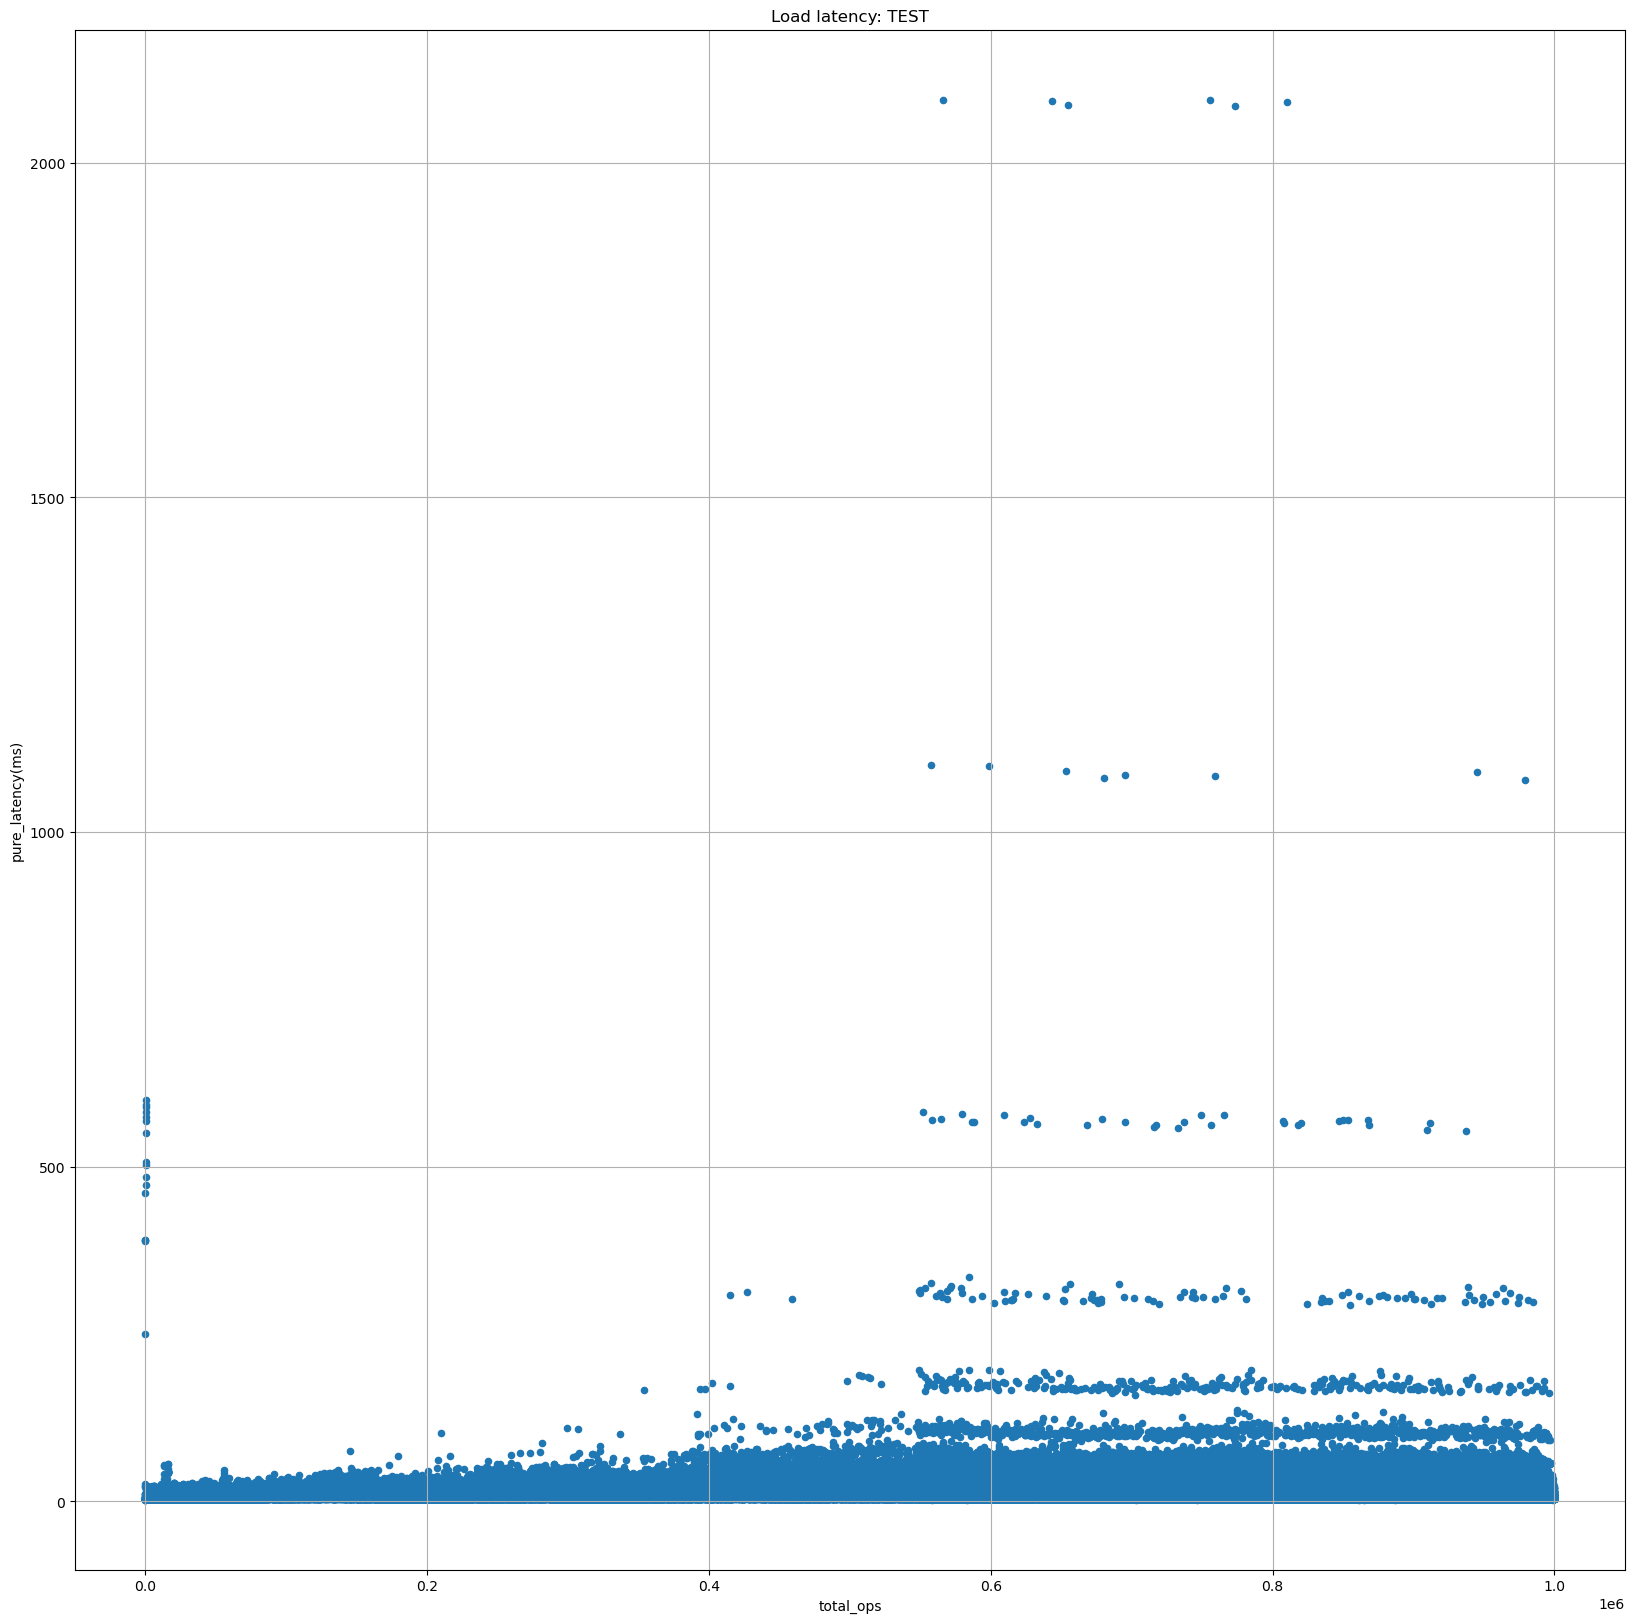

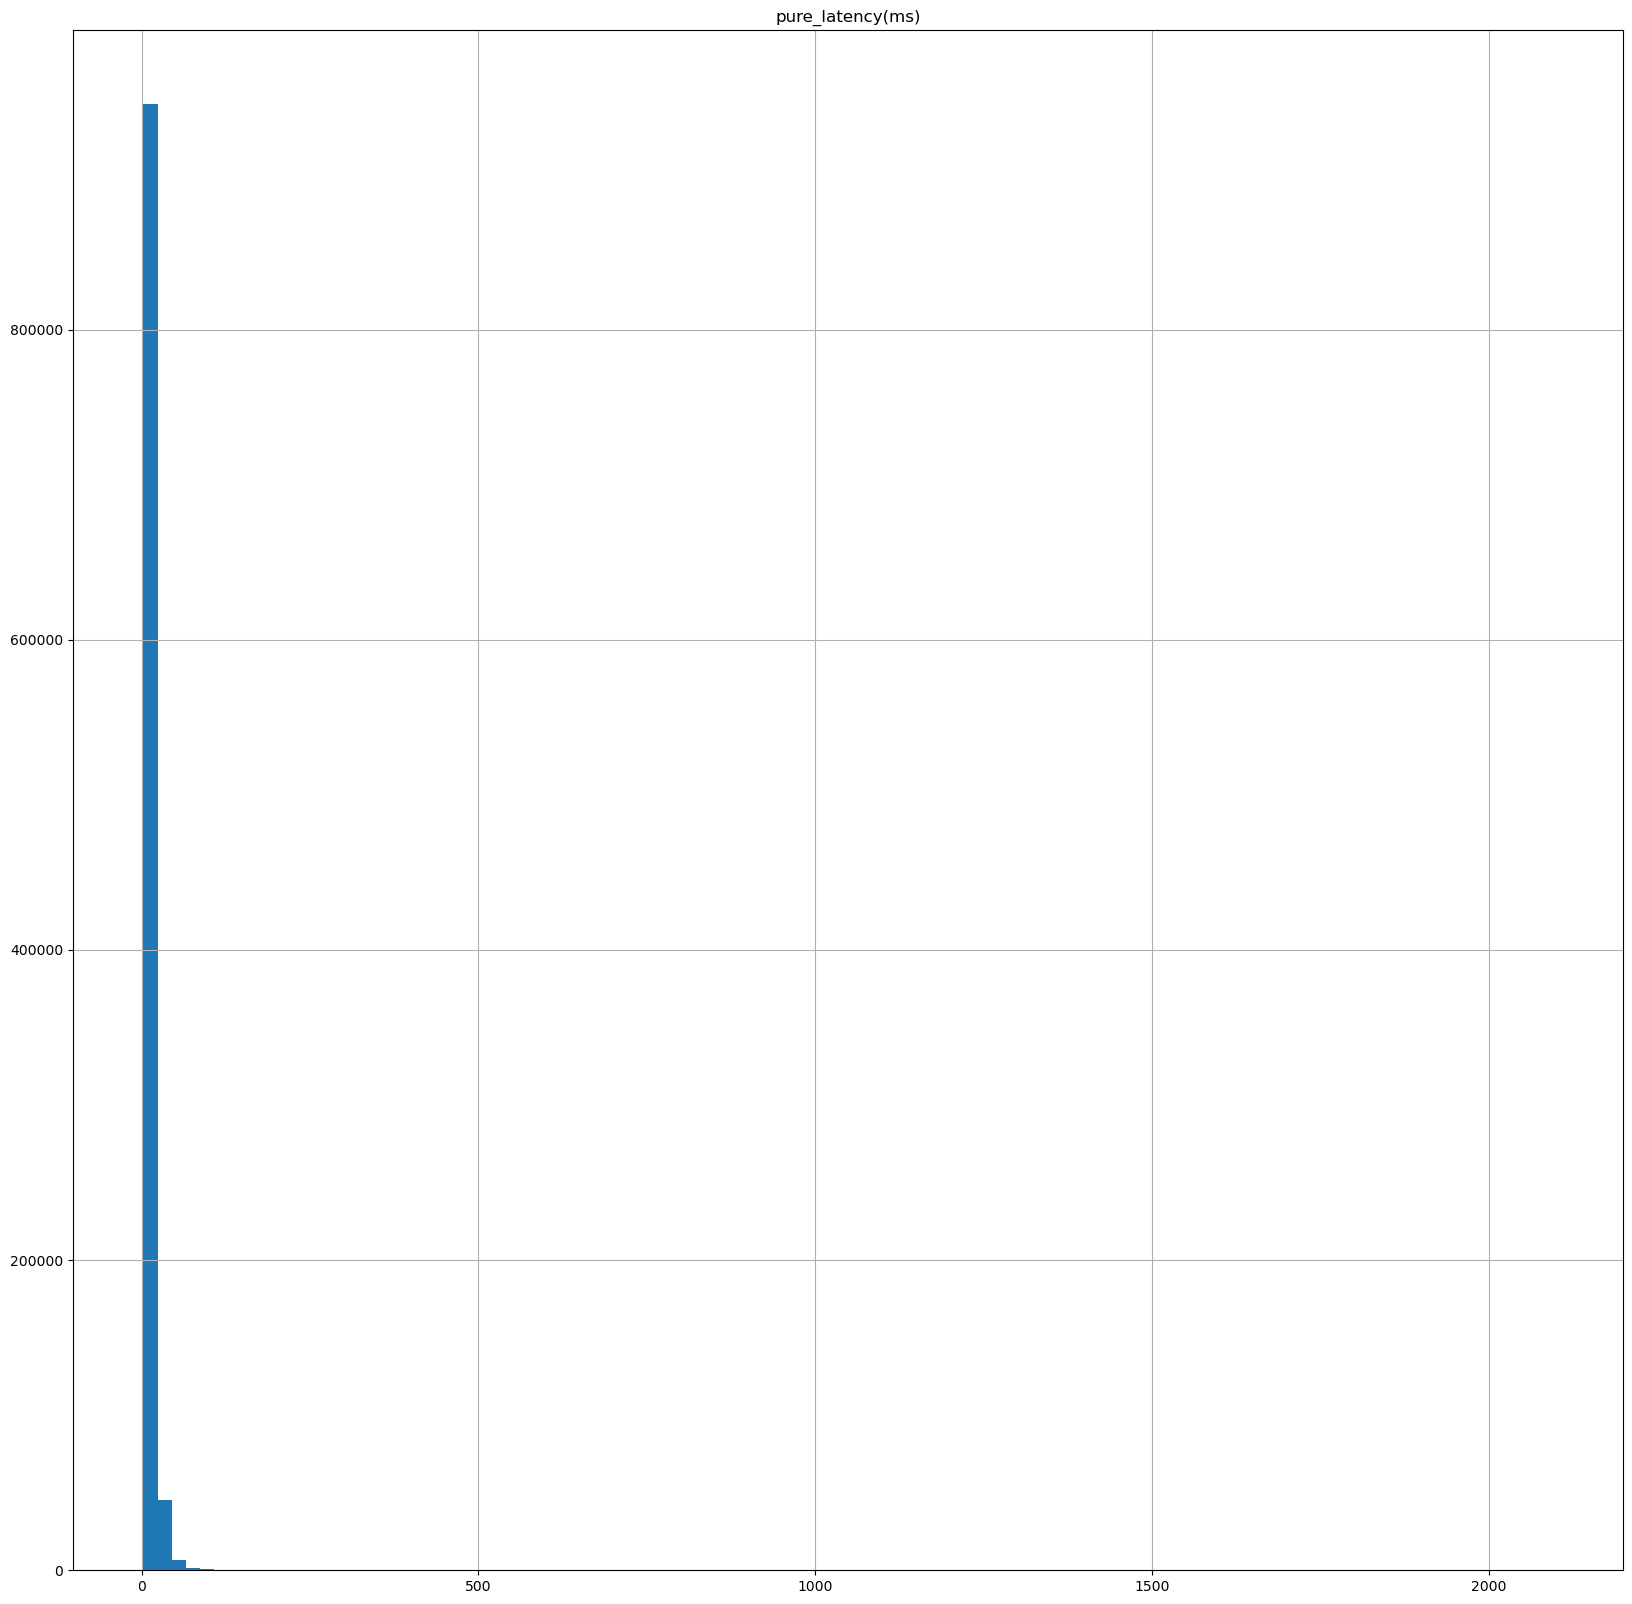

In [8]:
# df = get_summary_statistics_df(pc_e)


# df.to_csv("/tmp/summary.csv")
# df

df_w = pc_70_e.get_data().diff_data

# Graph scatter plot of latency
df_w.plot(figsize=(20,20), x="total_ops", y= "pure_latency(ms)", kind="scatter", title=f"Load latency: TEST", ylabel="pure_latency(ms)", grid=0.4)

# Graph latency with trend lines
# plot_latency_stats(df_w, "total_ops", title=f"{experiment} cf_{cf} thread_{tc} insert stats", regr="log", start=start, end=end)
# df_h = df_w.query("`pure_latency(ms)` < 10")

df_w.hist(figsize=(20,20), column= "pure_latency(ms)", bins=100, grid=0.4)

<AxesSubplot: title={'center': 'NEW ES2 Load: Average Latency'}, xlabel='ContentionFactor', ylabel='Average Latency'>

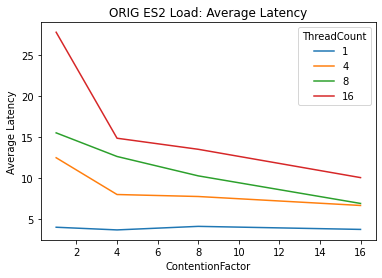

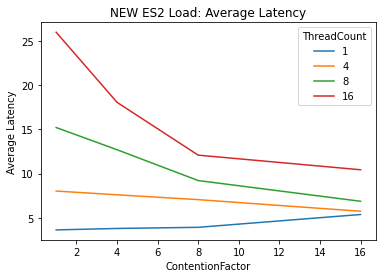

In [56]:
# Make a pivot table for average latency for load and graph it
query = "QueryNumber == 'load' & Experiment == 'es2'"

pd_orig = pandas.read_csv(csv_orig_file)

# un_pd1_orig = pd_orig.query("QueryNumber == 'load' & Experiment == 'es1'")
#un_piv_orig = un_pd1_orig.pivot(index='ContentionFactor', columns="ThreadCount", values="AverageLatencyMillis")

pd1_orig = pd_orig.query(query)
piv_orig = pd1_orig.pivot(index='ContentionFactor', columns="ThreadCount", values="AverageLatencyMillis")

pd_new = pandas.read_csv(csv_new_file)
pd1_new = pd_new.query(query)
piv_new = pd1_new.pivot(index='ContentionFactor', columns="ThreadCount", values="AverageLatencyMillis")


# un_pd1_orig.plot(title="ORIG ES1 Load: Average Latency", ylabel="Average Latency")

piv_orig.plot(title="ORIG ES2 Load: Average Latency", ylabel="Average Latency")
piv_new.plot(title="NEW ES2 Load: Average Latency", ylabel="Average Latency")
